In [3]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values
from dotenv import load_dotenv
import json
import re
import numpy as np
from sqlalchemy import create_engine, text
import pandas as pd
import re
import os
import json
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy import stats
# Add the parent directory to Python path so we can import from scripts
notebook_dir = os.path.abspath('')
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now import from scripts
from scripts.populate_database import (
    load_english_model,
    generate_embedding,
    MODELS_DIR,
    ENGLISH_MODEL_DIR
)

from tqdm.notebook import tqdm

# Load environment variables
load_dotenv()

# Configure database parameters
db_params = {
    'host': os.getenv('PGHOST', 'localhost'),
    'database': os.getenv('PGDATABASE', 'climate'),
    'user': os.getenv('PGUSER', 'climate'),
    'password': os.getenv('PGPASSWORD', 'climate'),
    'port': os.getenv('PGPORT', '5432')
}

# Verify the path addition worked
print(f"Parent directory added to path: {parent_dir}")
print(f"Current sys.path: {sys.path}")

Parent directory added to path: c:\Users\nayrb\Documents\problem-set-2-Nayrbnat
Current sys.path: ['c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat', 'C:\\Users\\nayrb\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\nayrb\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\nayrb\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\nayrb\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat\\venv_working', '', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat\\venv_working\\lib\\site-packages', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat\\venv_working\\lib\\site-packages\\win32', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat\\venv_working\\lib\\site-packages\\win32\\lib', 'c:\\Users\\nayrb\\Documents\\problem-set-2-Nayrbnat\\venv_working\\lib\\site-packages\\Pythonwin', 'C:\\Users\\nayrb\\Documents\\problem-set-2-Na

# Part 1: Similarity Search (Transformer Embeddings)
- This part of the notebook explains what the `emissions_target_search.py` does
- The idea here is to extract the most similar countries to a given country based on the target question prompt
- Each embedding method will output the top 2 similar responeses to the target prompt for each country
- As a robustness check, multiple different queries will be used in different languages ()

In [4]:
# Importing the embeddings from the results folder
df_similarity = pd.read_csv('../data/results/similarity_search_results.csv')

# For a fair comparison, we need to only include the english chunks to compare with word2vec
df_similarity = df_similarity[df_similarity['doc_language'] == 'English']
df_similarity.head(5)

,chunk_id,doc_id,country,content,chunk_metadata,chunk_index,doc_language,chunk_language,similarity_score,keyword_boost,percentage_boost,total_score,embedding_type,extracted_percentage,extracted_year,target_text,page_number,element_type
20,1309,canada_english_20250201,Canada,"Despite this rapid growth, the most recent Nat...","{'country': 'Canada', 'filename': 'canada_engl...",NaN,English,en,0.975890,0.15,0.15,1.275890,word2vec,1.9,2023.0,"Despite this rapid growth, the most recent Nat...",69.0,Unknown
21,812,canada_english_20250201,Canada,"For instance, the Clean Fuel Regulations are l...","{'country': 'Canada', 'filename': 'canada_engl...",NaN,English,en,0.965881,0.15,0.15,1.265881,word2vec,80,NaN,"For instance, the Clean Fuel Regulations are l...",6.0,Unknown
22,1734,canada_english_20250201,Canada,Similarly incongruent are the political and le...,"{'country': 'Canada', 'filename': 'canada_engl...",NaN,English,en,0.991801,0.10,0.15,1.241801,word2vec,30,NaN,Similarly incongruent are the political and le...,121.0,Unknown
23,1788,canada_english_20250201,Canada,Goal 7: Affordable and Clean Energy aims to en...,"{'country': 'Canada', 'filename': 'canada_engl...",NaN,English,en,0.988537,0.10,0.15,1.238537,word2vec,6,2022.0,Goal 7: Affordable and Clean Energy aims to en...,127.0,Unknown
24,789,canada_english_20250201,Canada,The economic impacts of rising global temperat...,"{'country': 'Canada', 'filename': 'canada_engl...",NaN,English,en,0.988325,0.10,0.15,1.238325,word2vec,6,NaN,The economic impacts of rising global temperat...,1.0,Unknown


# Part 2: Similarity Search (Word2Vec Embeddings)
- To compare against the similarity search done by the transformer, we will conduct a similarity search using the word2Vec embeddings
- The word2Vec embeddings can be found in the NB02-embedding comparison notebook


In [5]:
def safe_extract_target_percentage(text):

    """
    Safely extract percentage values related to emissions targets from text.
    
    Parameters:
    -----------
    text : str
        The text content to extract percentage values from
        
    Returns:
    --------
    str or None
        Extracted percentage value as a string, or None if no valid percentage found
    """
    if not isinstance(text, str) or not text:
        return None
        
    try:
        # Pattern 1: Match common percentage patterns related to emissions targets
        # Looks for numbers followed by % with potential keywords before/after
        percentage_patterns = [
            # Basic percentage pattern with target-related context
            r'(?:reduce|reduction|cut|decrease|lower|target|goal|pledge|commit|aim|by|of)\s+(?:emissions|emission|ghg|co2|carbon|greenhouse gas)?\s*(?:by|of)?\s*(\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)?%)',
            
            # Percentage at beginning of phrase
            r'(\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)?%)\s+(?:reduction|decrease|cut|below|compared)',
            
            # Range of percentages
            r'(?:between|from)\s+(\d+(?:\.\d+)?%?\s*(?:and|to)\s*\d+(?:\.\d+)?%)',
            
            # Percentage with 'by 2030' or similar context
            r'(\d+(?:\.\d+)?%)[^.]*?by\s+(?:20\d\d)',
            
            # Fallback: any percentage in context of emissions
            r'(?:emission|carbon|ghg)[^.]*?(\d+(?:\.\d+)?%)',
            
            # Last resort: any percentage pattern
            r'(\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)?%)'
        ]
        
        for pattern in percentage_patterns:
            matches = re.findall(pattern, text.lower())
            if matches:
                # Clean up the extracted percentage
                percentage = matches[0].strip()
                # Handle cases where regex capture group might capture extra text
                if isinstance(percentage, tuple):
                    percentage = percentage[0]
                # Ensure it actually contains a % symbol
                if '%' in percentage:
                    return percentage
        
        # Special case: look for numbers followed by "percent" word
        percent_word_pattern = r'(\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)?)\s+percent'
        percent_matches = re.findall(percent_word_pattern, text.lower())
        if percent_matches:
            return f"{percent_matches[0]}%"
        
        # Special case: look for written percentages (e.g., "fifteen percent")
        written_numbers = {
            'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5',
            'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10',
            'eleven': '11', 'twelve': '12', 'thirteen': '13', 'fourteen': '14', 'fifteen': '15',
            'sixteen': '16', 'seventeen': '17', 'eighteen': '18', 'nineteen': '19', 'twenty': '20',
            'twenty-five': '25', 'thirty': '30', 'forty': '40', 'fifty': '50',
            'sixty': '60', 'seventy': '70', 'eighty': '80', 'ninety': '90'
        }
        
        written_pattern = '|'.join(written_numbers.keys())
        written_regex = fr'({written_pattern})\s+percent'
        written_matches = re.findall(written_regex, text.lower())
        
        if written_matches and written_matches[0] in written_numbers:
            return f"{written_numbers[written_matches[0]]}%"
            
        return None
        
    except Exception as e:
        # In case of any error, return None to ensure function doesn't crash
        print(f"Error extracting percentage: {e}")
        return None
    
def safe_extract_target_year(text):
    """
    Safely extract target years related to emissions goals from text.
    
    Parameters:
    -----------
    text : str
        The text content to extract year values from
        
    Returns:
    --------
    str or None
        Extracted year value as a string, or None if no valid year found
    """
    if not isinstance(text, str) or not text:
        return None
        
    try:
        # Pattern 1: Match target years in common climate policy contexts
        # Looks for year mentions that are likely associated with emissions targets
        year_patterns = [
            # Year after "by" in target context
            r'(?:by|until|in|before|from)\s+(?:the\s+year\s+)?(20[0-9]{2})(?:\s+level)?',
            
            # Year in reference to baseline
            r'(?:compared\s+to|relative\s+to|from|baseline|reference\s+year)\s+(?:the\s+year\s+)?((?:19|20)[0-9]{2})',
            
            # Year as target in NDC context
            r'(?:NDC|INDC|commitment|pledge|target|goal)s?\s+(?:for|by|in)\s+(?:the\s+year\s+)?(20[0-9]{2})',
            
            # Target/percentage with year
            r'(?:[0-9]+(?:\.[0-9]+)?%)[^.]*?(?:by|in|before)\s+(?:the\s+year\s+)?(20[0-9]{2})',
            
            # Net-zero by year
            r'(?:net[- ]zero|carbon[- ]neutral(?:ity)?|climate[- ]neutral(?:ity)?)[^.]*?(?:by|in|before)\s+(?:the\s+year\s+)?(20[0-9]{2})',
            
            # Years specifically mentioned with 2030 (common NDC target)
            r'(?:20[0-9]{2}(?:\s*-\s*|\s+and\s+|\s+to\s+))?2030',
            
            # Generic year pattern as fallback (bias toward future years)
            r'(?:20[2-9][0-9])'
        ]
        
        for pattern in year_patterns:
            matches = re.findall(pattern, text.lower())
            if matches:
                # Clean up the extracted year
                year = matches[0].strip()
                if year.isdigit() and len(year) == 4 and year.startswith(('19', '20')):
                    return year
        
        # Special case for long-term goals
        long_term_patterns = [
            r'(?:long[- ]term|long[- ]range)\s+(?:goal|target|objective)[^.]*?(20[0-9]{2})',
            r'(?:mid[- ]century|by\s+(?:the\s+)?mid[- ]century)',
            r'(?:by\s+)?2050'
        ]
        
        for pattern in long_term_patterns:
            matches = re.findall(pattern, text.lower())
            if matches:
                if matches[0].isdigit():
                    return matches[0]
                elif 'mid-century' in text.lower() or 'mid century' in text.lower():
                    return '2050'  # Standard interpretation of mid-century
        
        # Examine common explicit target years in climate policy
        common_years = ['2020', '2025', '2030', '2035', '2040', '2045', '2050', '2060', '2070', '2100']
        for year in common_years:
            if year in text:
                # Verify it's not part of a different number
                year_pattern = r'\b' + year + r'\b'
                if re.search(year_pattern, text):
                    return year
                    
        return None
        
    except Exception as e:
        # In case of any error, return None to ensure function doesn't crash
        print(f"Error extracting year: {e}")
        return None

In [6]:
def search_with_word2vec(query=None, similarity_threshold=0.65, max_results_per_country=20):
    """
    Perform similarity search using word2vec embeddings from the database
    
    Parameters:
    -----------
    query : str, optional
        The search query for finding emissions targets
    similarity_threshold : float, optional
        Minimum cosine similarity score to include in results
    max_results_per_country : int, optional
        Maximum number of results to return per country
        
    Returns:
    --------
    pandas.DataFrame
        Results of the similarity search
    """
    if query is None:
        query = "What emissions reduction target is each country in the NDC registry aiming for by 2030?"
    
    print(f"Searching with query: {query}")
    
    # Create database connection
    db_url = f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["database"]}'
    engine = create_engine(db_url)
    
    # Enhance the query for better targeting
    enhanced_query = query + " emissions reduction targets NDCs 2030 percentage reductions baseline years conditional unconditional greenhouse gas CO2 carbon net-zero climate goals"
    print(f"Enhanced query: {enhanced_query}")
    
    try:
        # Use SQL to retrieve relevant chunks with their word2vec embeddings
        with engine.connect() as conn:
            sql_query = text("""
                SELECT 
                    c.id,
                    c.doc_id,
                    d.country,
                    c.content,
                    c.chunk_metadata,
                    c.chunk_index,
                    d.language as doc_language,
                    c.language as chunk_language,
                    c.word2vec_embedding,
                    -- Calculate keyword boost
                    (CASE WHEN c.content ~* 'emission|reduction|target|ndc|2030|co2|carbon|ghg' THEN 0.1 ELSE 0 END) +
                    (CASE WHEN c.content ~* 'percent|baseline|conditional|unconditional' THEN 0.05 ELSE 0 END) AS keyword_boost,
                    -- Percentage pattern boost
                    (CASE WHEN c.content ~ '[0-9]+([.][0-9]+)?%' THEN 0.15 ELSE 0 END) AS percentage_boost
                FROM 
                    doc_chunks c
                JOIN
                    documents d ON c.doc_id = d.doc_id
                WHERE 
                    c.word2vec_embedding IS NOT NULL
                    -- Filter for relevant content
                    AND c.content ~* 'target|emission|reduction|climate|goal|pledge|commitment|2030'
                ORDER BY
                    d.country
            """)
            
            try:
                result = conn.execute(sql_query)
                rows = result.fetchall()
                if not rows:
                    print("No word2vec results found. Please check if word2vec embeddings exist in the database.")
                    return pd.DataFrame()
            except Exception as e:
                print(f"Database query error: {e}")
                return pd.DataFrame()
        
        # Process the results
        results = []
        for row in rows:
            chunk_id = row[0]
            doc_id = row[1]
            country = row[2]
            content = row[3]  # Changed variable name from text to content
            metadata_json = row[4]
            chunk_index = row[5]
            doc_language = row[6]
            chunk_language = row[7]
            embedding_str = row[8]
            keyword_boost = float(row[9]) if row[9] is not None else 0.0
            percentage_boost = float(row[10]) if row[10] is not None else 0.0
            
            # Parse metadata more robustly
            metadata = {}
            if metadata_json:
                if isinstance(metadata_json, dict):
                    metadata = metadata_json
                elif isinstance(metadata_json, str):
                    try:
                        metadata = json.loads(metadata_json)
                    except json.JSONDecodeError:
                        # Try to extract values from malformed JSON using regex as a fallback
                        try:
                            # Simple regex to extract key-value pairs
                            page_match = re.search(r'"page_number"\s*:\s*"?(\w+)"?', metadata_json)
                            if page_match:
                                metadata['page_number'] = page_match.group(1)
                                
                            element_match = re.search(r'"element_type"\s*:\s*"?(\w+)"?', metadata_json)
                            if element_match:
                                metadata['element_type'] = element_match.group(1)
                        except:
                            pass
            
            # Extract key metadata fields directly for safety
            page_number = metadata.get('page_number', 'Unknown') if isinstance(metadata, dict) else 'Unknown'
            element_type = metadata.get('element_type', 'Unknown') if isinstance(metadata, dict) else 'Unknown'
            
            # Store results with a placeholder similarity score
            results.append({
                'country': country,
                'content': content,  # Using content instead of text
                'doc_id': doc_id,
                'chunk_id': chunk_id,
                'embedding_str': embedding_str,
                'keyword_boost': keyword_boost,
                'percentage_boost': percentage_boost,
                'chunk_metadata': metadata,
                'page_number': page_number,  # Store directly
                'element_type': element_type,  # Store directly
                'embedding_type': 'word2vec'
            })
        
        # Convert to DataFrame
        df = pd.DataFrame(results)
        
        if df.empty:
            print("No results found with word2vec embeddings.")
            return pd.DataFrame()
            
        # Extract embeddings from PostgreSQL format
        def extract_embedding(embedding_str):
            if embedding_str and isinstance(embedding_str, str):
                try:
                    # Handle both [1,2,3] format and {1,2,3} format
                    if embedding_str.startswith('[') and embedding_str.endswith(']'):
                        embedding_str = embedding_str[1:-1]
                    elif embedding_str.startswith('{') and embedding_str.endswith('}'):
                        embedding_str = embedding_str[1:-1]
                    
                    # Split by comma and convert to float
                    return np.array([float(x) for x in embedding_str.split(',')])
                except (ValueError, TypeError) as e:
                    print(f"Error parsing embedding: {e}")
                    return None
            return None
            
        df['embedding_vector'] = df['embedding_str'].apply(extract_embedding)
        
        # Remove rows with invalid embeddings
        df = df.dropna(subset=['embedding_vector'])
        
        if df.empty:
            print("No valid word2vec embeddings found after parsing.")
            return pd.DataFrame()
        
        # For a query embedding, we'll use a simple approach: average some relevant embeddings
        try:
            relevant_embeddings = df[df['keyword_boost'] > 0]['embedding_vector'].tolist()
            if len(relevant_embeddings) >= 3:
                # Use several relevant embeddings
                query_embedding = np.mean(relevant_embeddings[:10], axis=0)
            else:
                # If not enough relevant embeddings, use mean of all
                all_embeddings = df['embedding_vector'].tolist()
                query_embedding = np.mean(np.vstack(all_embeddings[:20]), axis=0)
                
            # Calculate similarity scores
            df['similarity_score'] = df['embedding_vector'].apply(
                lambda x: float(cosine_similarity([query_embedding], [x])[0][0]) if x is not None else 0.0
            )
        except Exception as e:
            print(f"Error calculating embeddings: {e}")
            # Fallback: if similarity calculation fails, use a default score
            df['similarity_score'] = 0.5
        
        # Calculate total score
        df['total_score'] = df['similarity_score'] + df['keyword_boost'] + df['percentage_boost']
        
        # Filter by similarity threshold or boost
        filtered_df = df[(df['similarity_score'] >= similarity_threshold) | 
                         (df['keyword_boost'] > 0) | 
                         (df['percentage_boost'] > 0)].copy()
        
        if filtered_df.empty:
            print("No results found above the similarity threshold.")
            return pd.DataFrame()
        
        # No need to re-extract metadata fields since we already have them
        # But let's ensure they exist and have the correct type
        if 'page_number' not in filtered_df.columns:
            filtered_df['page_number'] = 'Unknown'
        if 'element_type' not in filtered_df.columns:
            filtered_df['element_type'] = 'Unknown'
              
        # Apply extraction functions
        filtered_df['extracted_percentage'] = filtered_df['content'].apply(safe_extract_target_percentage)
        filtered_df['extracted_year'] = filtered_df['content'].apply(safe_extract_target_year)
        filtered_df['target_text'] = filtered_df['content']  # For consistency
        
        # Keep only the top results per country
        top_results = []
        for country, group in filtered_df.groupby('country'):
            group = group.sort_values('total_score', ascending=False)
            top_results.append(group.head(max_results_per_country))
        
        # Combine results
        if top_results:
            final_df = pd.concat(top_results)
            final_df = final_df.sort_values(['country', 'total_score'], ascending=[True, False])
            
            # Clean up the DataFrame - remove unnecessary columns
            cols_to_drop = ['embedding_str', 'embedding_vector']
            final_df = final_df.drop(columns=[c for c in cols_to_drop if c in final_df.columns])
        else:
            final_df = pd.DataFrame()
        
        # Save results to CSV
        if not final_df.empty:
            results_dir = os.path.join('..', 'data', 'results')
            os.makedirs(results_dir, exist_ok=True)
            output_file = os.path.join(results_dir, 'word2vec_search_results.csv')
            final_df.to_csv(output_file, index=False)
            print(f"Results saved to {output_file}")
        
        return final_df
    
    except Exception as e:
        print(f"Error in word2vec search: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()
    finally:
        print("Database connection closed")

In [7]:
# Run the word2vec search with the same query as used in emissions_target_search.py
standard_query = "What emissions reduction target is each country in the NDC registry aiming for by 2030?"
word2vec_df = search_with_word2vec(query=standard_query)

# Display the top results
if not word2vec_df.empty:
    print(f"Found {len(word2vec_df)} results across {word2vec_df['country'].nunique()} countries")
    display(word2vec_df.head(5))

Searching with query: What emissions reduction target is each country in the NDC registry aiming for by 2030?
Enhanced query: What emissions reduction target is each country in the NDC registry aiming for by 2030? emissions reduction targets NDCs 2030 percentage reductions baseline years conditional unconditional greenhouse gas CO2 carbon net-zero climate goals
Results saved to ..\data\results\word2vec_search_results.csv
Database connection closed
Found 220 results across 11 countries


,country,content,doc_id,chunk_id,keyword_boost,percentage_boost,chunk_metadata,page_number,element_type,embedding_type,similarity_score,total_score,extracted_percentage,extracted_year,target_text
10,Andorra,estableix un objectiu de reducció del 63% de l...,andorra_spanish_20250201,108,0.1,0.15,"{'country': 'Andorra', 'filename': 'andorra_sp...",4,Unknown,word2vec,0.974472,1.224472,63%,None,estableix un objectiu de reducció del 63% de l...
17,Andorra,El objetivo para 2035 es una reducción del 63%...,andorra_spanish_20250201,665,0.1,0.15,"{'country': 'Andorra', 'filename': 'andorra_sp...",14,Unknown,word2vec,0.968183,1.218183,63%,2035,El objetivo para 2035 es una reducción del 63%...
8,Andorra,del objetivo de reducir en un 20% la intensida...,andorra_spanish_20250201,430,0.1,0.15,"{'country': 'Andorra', 'filename': 'andorra_sp...",10,Unknown,word2vec,0.960514,1.210514,20%,2030,del objetivo de reducir en un 20% la intensida...
4,Andorra,de disminuir en un 50% las emisiones procedent...,andorra_spanish_20250201,402,0.1,0.15,"{'country': 'Andorra', 'filename': 'andorra_sp...",10,Unknown,word2vec,0.959352,1.209352,50%,2030,de disminuir en un 50% las emisiones procedent...
12,Andorra,nacional cubra al menos el 33% de la demanda p...,andorra_spanish_20250201,289,0.1,0.15,"{'country': 'Andorra', 'filename': 'andorra_sp...",9,Unknown,word2vec,0.956018,1.206018,33%,2030,nacional cubra al menos el 33% de la demanda p...


In [8]:
# Extract language information from doc_id
def extract_language(doc_id):
    """Extract language identifier from doc_id like 'country_english_20220602'"""
    try:
        # Split by underscore and get the middle part
        parts = doc_id.split('_')
        if len(parts) >= 2:
            return parts[1]
        else:
            return None
    except:
        return None

# Apply the extraction function
word2vec_df['doc_language_extracted'] = word2vec_df['doc_id'].apply(extract_language)

# Count languages to verify extraction worked
print("\nExtracted languages:")
print(word2vec_df['doc_language_extracted'].value_counts())

# Filter to only English documents
word2vec_df = word2vec_df[word2vec_df['doc_language_extracted'] == 'english']


print(f"English only DataFrame: {len(word2vec_df)} rows")
print(f"English documents cover {word2vec_df['country'].nunique()} countries")
word2vec_df.head(5)


Extracted languages:
doc_language_extracted
english    140
spanish     40
islands     20
lucia       20
Name: count, dtype: int64
English only DataFrame: 140 rows
English documents cover 7 countries


,country,content,doc_id,chunk_id,keyword_boost,percentage_boost,chunk_metadata,page_number,element_type,embedding_type,similarity_score,total_score,extracted_percentage,extracted_year,target_text,doc_language_extracted
356,Canada,"11 decarbonization of industrial sectors, and ...",canada_english_20250201,866,0.15,0.15,"{'country': 'Canada', 'filename': 'canada_engl...",9,Unknown,word2vec,0.581860,0.881860,35%,2035,"11 decarbonization of industrial sectors, and ...",english
363,Canada,3. Scope and coverage: General description of ...,canada_english_20250201,876,0.10,0.15,"{'country': 'Canada', 'filename': 'canada_engl...",14,Unknown,word2vec,0.585925,0.835925,45%,2035,3. Scope and coverage: General description of ...,english
456,Canada,"Despite this rapid growth, the most recent Nat...",canada_english_20250201,1309,0.15,0.15,"{'country': 'Canada', 'filename': 'canada_engl...",69,Unknown,word2vec,0.527309,0.827309,1.9%,2023,"Despite this rapid growth, the most recent Nat...",english
360,Canada,Not applicable. (b) (c) A 45-50% reduction in ...,canada_english_20250201,870,0.10,0.15,"{'country': 'Canada', 'filename': 'canada_engl...",9,Unknown,word2vec,0.573532,0.823532,45-50%,2005,Not applicable. (b) (c) A 45-50% reduction in ...,english
359,Canada,(a) The reference indicator will be quantified...,canada_english_20250201,869,0.10,0.15,"{'country': 'Canada', 'filename': 'canada_engl...",9,Unknown,word2vec,0.568959,0.818959,45-50%,2005,(a) The reference indicator will be quantified...,english


# Part 3 - Classifying what is a good chunk or not

In [9]:
def is_good_chunk(chunk, min_relevance_score=0.7, require_percentage=True):
    """
    Evaluates if a chunk contains valuable information about emission targets.
    
    Parameters:
    -----------
    chunk : dict or pandas Series
        The document chunk with content, extracted_percentage, extracted_year, etc.
    min_relevance_score : float, optional
        Minimum relevance score threshold (0-1)
    require_percentage : bool, optional
        Whether to strictly require a percentage to be present
        
    Returns:
    --------
    bool
        True if the chunk is considered a good source of emissions target information
    dict
        Details about why the chunk was rated as it was
    """
    if isinstance(chunk, pd.Series):
        content = chunk.get('content', '')
        extracted_percentage = chunk.get('extracted_percentage')
        extracted_year = chunk.get('extracted_year')
        similarity_score = chunk.get('similarity_score', 0)
        keyword_boost = chunk.get('keyword_boost', 0)
        percentage_boost = chunk.get('percentage_boost', 0)
    else:
        content = chunk.get('content', '')
        extracted_percentage = chunk.get('extracted_percentage')
        extracted_year = chunk.get('extracted_year')
        similarity_score = chunk.get('similarity_score', 0)
        keyword_boost = chunk.get('keyword_boost', 0)
        percentage_boost = chunk.get('percentage_boost', 0)
    
    # Initialize evaluation details
    details = {
        'has_percentage': extracted_percentage is not None,
        'has_year': extracted_year is not None,
        'keyword_score': 0,
        'relevance_phrases': [],
        'semantic_relevance': similarity_score,
        'total_relevance': 0
    }
    
    # Check for percentage values (strongly required)
    if require_percentage and not details['has_percentage']:
        return False, details
    
    # Check for key phrases about emission targets
    key_phrases = [
        ('emissions reduction target', 3),
        ('reduce emissions by', 3),
        ('ghg emissions', 2),
        ('carbon dioxide emissions', 2),
        ('emissions reduction goal', 3),
        ('ndc target', 3),
        ('unconditional target', 3),
        ('conditional target', 3),
        ('percentage reduction', 3),
        ('reduction from baseline', 3),
        ('business as usual', 2),
        ('carbon intensity', 2),
        ('greenhouse gas emissions', 2),
        ('reference scenario', 1),
        ('compared to', 1),
        ('relative to', 1),
        ('by 2030', 2),
        ('net zero', 2),
        ('carbon neutrality', 2)
    ]
    
    content_lower = content.lower() if content else ''
    
    for phrase, score in key_phrases:
        if phrase in content_lower:
            details['keyword_score'] += score
            details['relevance_phrases'].append(phrase)
    
    # Calculate total relevance
    details['total_relevance'] = (
        (0.4 * similarity_score) + 
        (0.3 * min(1.0, details['keyword_score'] / 10)) + 
        (0.2 * int(details['has_percentage'])) + 
        (0.1 * int(details['has_year']))
    )
    
    # Check if it meets the minimum relevance threshold
    is_good = details['total_relevance'] >= min_relevance_score
    
    # Special case: if it has specific emissions target language AND a percentage, 
    # consider it good regardless of other factors
    has_target_language = any(phrase in content_lower for phrase in [
        'emissions reduction target', 'reduce emissions by', 
        'ndc target', 'unconditional target', 'conditional target'
    ])
    
    if has_target_language and details['has_percentage']:
        is_good = True
    
    return is_good, details

# 🔍 Understanding the `is_good_chunk` Function: Evaluating Climate Target Information

## 📊 What This Function Does

The `is_good_chunk` function acts as a **quality filter** for document chunks containing climate emissions targets. It evaluates text passages to determine whether they contain reliable, specific information about a country's emissions reduction goals.

Think of it as a "gold prospector" for climate data - separating valuable nuggets of emissions target information from vague or irrelevant content.

## 🏆 What Makes a "Good" Chunk?

### Essential Components

1. **📝 Percentage Values** (Critical)
   * By default, a chunk *must* contain a numerical percentage (e.g., "15%", "25-30%")
   * This represents the actual emissions reduction target
   * Can be disabled, but percentages are the "gold standard" of specificity

2. **📅 Target Years** (Helpful)
   * Dates like "2030" that indicate when the target should be reached
   * Provides temporal context for the percentage goal

3. **🔑 Key Phrases** (Important)
   * Climate policy terminology is weighted by importance:
     * High value (3 points): "emissions reduction target", "reduce emissions by", "NDC target"
     * Medium value (2 points): "GHG emissions", "carbon intensity", "by 2030" 
     * Basic value (1 point): "compared to", "relative to", "reference scenario"

4. **🧠 Semantic Relevance** (Background)
   * The similarity score from embedding comparison
   * Measures how closely the content matches the emissions target query

### 🧮 Relevance Calculation

The function combines these factors using a weighted formula:



Total Relevance = (0.4 × Semantic Similarity) + 
                  (0.3 × Keyword Score) +
                  (0.2 × Has Percentage) +
                  (0.1 × Has Year)



## 🎯 Decision Rules

A chunk is classified as "good" if **either**:

1. **📈 Total relevance score ≥ threshold** (default: 0.7)
   * Balanced approach using all factors

2. **💯 Contains specific target language AND percentage**
   * Explicit override for high-quality targets
   * Example: "reduce emissions by 25% by 2030"

## 🌟 In Simple Terms

A good chunk is text that:
* Contains specific numbers (percentages) about emissions reduction
* Uses technical language about targets and commitments
* Clearly relates to a country's climate goals
* Ideally includes target dates like 2030

This function helps identify the most concrete, actionable information about each country's emissions reduction plans amid lengthy policy documents.

### Part 3a: Classifying word2vec embeddings as good chunks or not

In [10]:
# Apply to dataframe, ensuring chunk_details is never None
word2vec_df['is_good_chunk'], word2vec_df['chunk_details'] = zip(*word2vec_df.apply(
    lambda x: is_good_chunk(x, min_relevance_score=0.6), axis=1
))

# Filter to good chunks only
good_chunks = word2vec_df[word2vec_df['is_good_chunk']]

# Get chunks with specific characteristics
high_confidence_targets = word2vec_df[
    word2vec_df.apply(
        lambda x: is_good_chunk(x, min_relevance_score=0.8, require_percentage=True)[0], 
        axis=1
    )
]

# Show summary of evaluation safely
print(f"Total chunks: {len(word2vec_df)}")
print(f"Good chunks: {word2vec_df['is_good_chunk'].sum()}")
print(f"Chunks with percentages: {word2vec_df['extracted_percentage'].notnull().sum()}")
print(f"Chunks with years: {word2vec_df['extracted_year'].notnull().sum()}")

# Safely compute average relevance score
def safe_get_relevance(details):
    if details is None:
        return 0.0
    return details.get('total_relevance', 0.0)

avg_relevance = word2vec_df['chunk_details'].apply(safe_get_relevance).mean()
print(f"Avg relevance score: {avg_relevance:.2f}")

Total chunks: 140
Good chunks: 27
Chunks with percentages: 86
Chunks with years: 88
Avg relevance score: 0.35


### Part 3b: Classifying transformer embeddings as good chunks or not

In [11]:
# Apply the extraction
df_similarity['extracted_percentage'] = df_similarity['content'].apply(safe_extract_target_percentage)
df_similarity['extracted_year'] = df_similarity['content'].apply(safe_extract_target_year)

# Apply to df_similarity, ensuring chunk_details is never None
df_similarity['is_good_chunk'], df_similarity['chunk_details'] = zip(*df_similarity.apply(
    lambda x: is_good_chunk(x, min_relevance_score=0.6), axis=1
))

# Filter to good chunks only
good_similarity_chunks = df_similarity[df_similarity['is_good_chunk']]

# Get chunks with specific characteristics
high_confidence_similarity_targets = df_similarity[
    df_similarity.apply(
        lambda x: is_good_chunk(x, min_relevance_score=0.8, require_percentage=True)[0], 
        axis=1
    )
]

# Show summary of evaluation safely
print(f"Total chunks in df_similarity: {len(df_similarity)}")
print(f"Good chunks: {df_similarity['is_good_chunk'].sum()}")
print(f"Chunks with percentages: {df_similarity['extracted_percentage'].notnull().sum()}")
print(f"Chunks with years: {df_similarity['extracted_year'].notnull().sum()}")

# Safely compute average relevance score
def safe_get_relevance(details):
    if details is None:
        return 0.0
    return details.get('total_relevance', 0.0)

avg_similarity_relevance = df_similarity['chunk_details'].apply(safe_get_relevance).mean()
print(f"Avg relevance score: {avg_similarity_relevance:.2f}")


Total chunks in df_similarity: 180
Good chunks: 100
Chunks with percentages: 121
Chunks with years: 116
Avg relevance score: 0.48


### Comparing Word2Vec and Transformer embeddings


Using 140 samples from each dataset for fair comparison
Sampled df_similarity from 180 to 140 rows
Re-evaluating chunks for fair comparison...

Fair Comparison between equal samples:
Total chunks: 140 vs 140
Good chunks: 78 vs 27
Good chunk ratio: 55.7% vs 19.3%
Chunks with percentages: 96 vs 86
Chunks with years: 88 vs 88
Avg relevance score: 0.49 vs 0.35


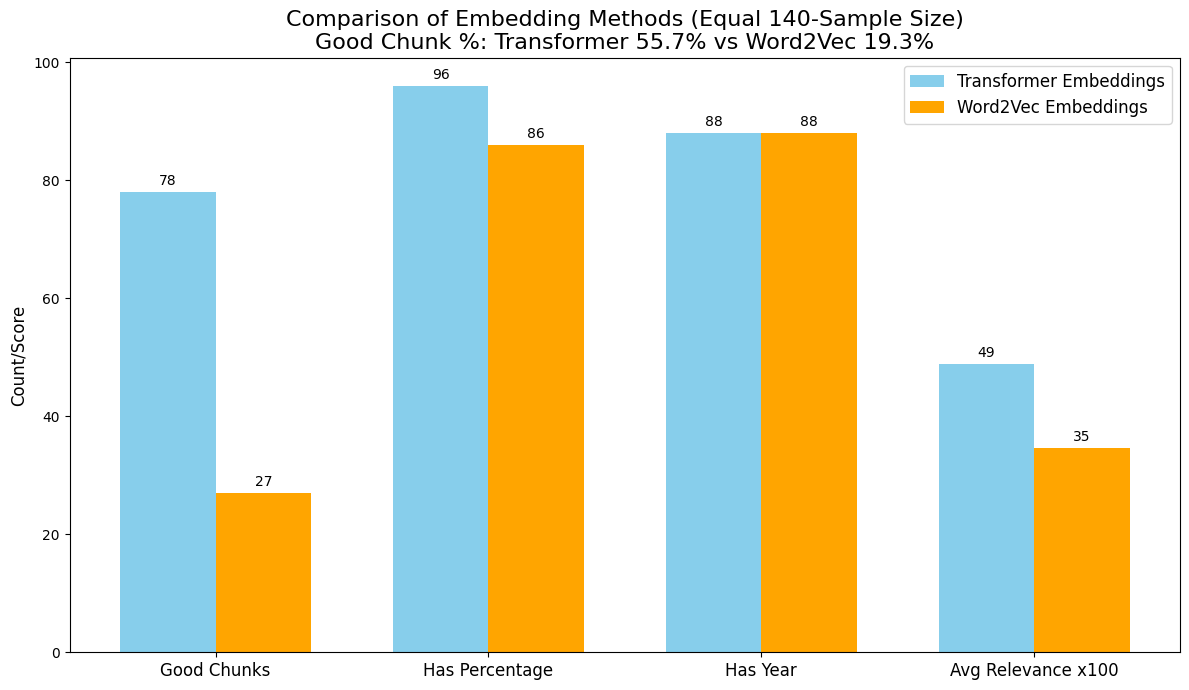


Statistical significance tests (Equal sample sizes):
Good chunks difference p-value: 0.0000 (significant)
Percentage extraction difference p-value: 0.2594 (not significant)
Year extraction difference p-value: 1.0000 (not significant)
Relevance score difference p-value: 0.0002 (significant)


In [12]:
# Compare with word2vec_df if it exists
if 'word2vec_df' in globals() and isinstance(word2vec_df, pd.DataFrame):
    # Determine the smaller sample size
    smaller_size = min(len(df_similarity), len(word2vec_df))
    print(f"\nUsing {smaller_size} samples from each dataset for fair comparison")
    
    # Take random samples of equal size if needed
    if len(df_similarity) > smaller_size:
        df_similarity_sample = df_similarity.sample(n=smaller_size, random_state=42)
        word2vec_sample = word2vec_df
        print(f"Sampled df_similarity from {len(df_similarity)} to {smaller_size} rows")
    elif len(word2vec_df) > smaller_size:
        df_similarity_sample = df_similarity
        word2vec_sample = word2vec_df.sample(n=smaller_size, random_state=42)
        print(f"Sampled word2vec_df from {len(word2vec_df)} to {smaller_size} rows")
    else:
        df_similarity_sample = df_similarity
        word2vec_sample = word2vec_df
        print("Both datasets already have the same number of samples")
    
    # Re-apply is_good_chunk to the samples to ensure fair comparison
    print("Re-evaluating chunks for fair comparison...")
    
    # For similarity df sample
    df_similarity_sample['is_good_chunk'], df_similarity_sample['chunk_details'] = zip(*df_similarity_sample.apply(
        lambda x: is_good_chunk(x, min_relevance_score=0.6), axis=1
    ))
    
    # For word2vec df sample
    word2vec_sample['is_good_chunk'], word2vec_sample['chunk_details'] = zip(*word2vec_sample.apply(
        lambda x: is_good_chunk(x, min_relevance_score=0.6), axis=1
    ))
    
    # Calculate relevance scores
    def safe_get_relevance(details):
        if details is None:
            return 0.0
        return details.get('total_relevance', 0.0)
    
    df_similarity_sample['relevance_score'] = df_similarity_sample['chunk_details'].apply(safe_get_relevance)
    word2vec_sample['relevance_score'] = word2vec_sample['chunk_details'].apply(safe_get_relevance)
    
    # Calculate metrics
    sim_avg_relevance = df_similarity_sample['relevance_score'].mean()
    w2v_avg_relevance = word2vec_sample['relevance_score'].mean()
    
    print("\nFair Comparison between equal samples:")
    print(f"Total chunks: {len(df_similarity_sample)} vs {len(word2vec_sample)}")
    print(f"Good chunks: {df_similarity_sample['is_good_chunk'].sum()} vs {word2vec_sample['is_good_chunk'].sum()}")
    print(f"Good chunk ratio: {df_similarity_sample['is_good_chunk'].mean():.1%} vs {word2vec_sample['is_good_chunk'].mean():.1%}")
    print(f"Chunks with percentages: {df_similarity_sample['extracted_percentage'].notnull().sum()} vs {word2vec_sample['extracted_percentage'].notnull().sum()}")
    print(f"Chunks with years: {df_similarity_sample['extracted_year'].notnull().sum()} vs {word2vec_sample['extracted_year'].notnull().sum()}")
    print(f"Avg relevance score: {sim_avg_relevance:.2f} vs {w2v_avg_relevance:.2f}")
    
    # Set up metrics for comparison with equal samples
    metrics = ['Good Chunks', 'Has Percentage', 'Has Year', 'Avg Relevance x100']
    similarity_values = [
        df_similarity_sample['is_good_chunk'].sum(),
        df_similarity_sample['extracted_percentage'].notnull().sum(),
        df_similarity_sample['extracted_year'].notnull().sum(),
        sim_avg_relevance * 100  # Scale for visibility
    ]
    word2vec_values = [
        word2vec_sample['is_good_chunk'].sum(),
        word2vec_sample['extracted_percentage'].notnull().sum(),
        word2vec_sample['extracted_year'].notnull().sum(),
        w2v_avg_relevance * 100  # Scale for visibility
    ]
    
    # Add percentage metrics for the chart title
    sim_good_pct = df_similarity_sample['is_good_chunk'].mean() * 100
    w2v_good_pct = word2vec_sample['is_good_chunk'].mean() * 100
    
    # Create plot
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, similarity_values, width, label='Transformer Embeddings', color='skyblue')
    rects2 = ax.bar(x + width/2, word2vec_values, width, label='Word2Vec Embeddings', color='orange')
    
    # Add labels and title
    ax.set_ylabel('Count/Score', fontsize=12)
    ax.set_title(f'Comparison of Embedding Methods (Equal {smaller_size}-Sample Size)\n'
                 f'Good Chunk %: Transformer {sim_good_pct:.1f}% vs Word2Vec {w2v_good_pct:.1f}%', 
                 fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.legend(fontsize=12)
    
    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.0f}' if height >= 1 else f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    plt.show()
    
    # Add a statistical significance test
 
    
    print("\nStatistical significance tests (Equal sample sizes):")
    
    # Test for good chunks
    _, p_good = stats.fisher_exact([
        [df_similarity_sample['is_good_chunk'].sum(), len(df_similarity_sample) - df_similarity_sample['is_good_chunk'].sum()],
        [word2vec_sample['is_good_chunk'].sum(), len(word2vec_sample) - word2vec_sample['is_good_chunk'].sum()]
    ])
    print(f"Good chunks difference p-value: {p_good:.4f} {'(significant)' if p_good < 0.05 else '(not significant)'}")
    
    # Test for percentages
    _, p_pct = stats.fisher_exact([
        [df_similarity_sample['extracted_percentage'].notnull().sum(), df_similarity_sample['extracted_percentage'].isnull().sum()],
        [word2vec_sample['extracted_percentage'].notnull().sum(), word2vec_sample['extracted_percentage'].isnull().sum()]
    ])
    print(f"Percentage extraction difference p-value: {p_pct:.4f} {'(significant)' if p_pct < 0.05 else '(not significant)'}")
    
    # Test for years
    _, p_year = stats.fisher_exact([
        [df_similarity_sample['extracted_year'].notnull().sum(), df_similarity_sample['extracted_year'].isnull().sum()],
        [word2vec_sample['extracted_year'].notnull().sum(), word2vec_sample['extracted_year'].isnull().sum()]
    ])
    print(f"Year extraction difference p-value: {p_year:.4f} {'(significant)' if p_year < 0.05 else '(not significant)'}")
    
    # Test for relevance scores (t-test)
    t_stat, p_rel = stats.ttest_ind(
        df_similarity_sample['relevance_score'].dropna(),
        word2vec_sample['relevance_score'].dropna(),
        equal_var=False  # Use Welch's t-test
    )
    print(f"Relevance score difference p-value: {p_rel:.4f} {'(significant)' if p_rel < 0.05 else '(not significant)'}")
else:
    print("word2vec_df not found or not a DataFrame. Cannot create comparison.")

# Part 4: Applying relevant thresholds for Word2Vec Embeddings
- Currently we are using a minimum similarity of **0.65** to determine the similarity of chunks to the query. This next stage is to test out different thresholds to see how the results change.
- This 0.65 refers to the `SIMILARITY_THRESHOLD` variable in the emissions_target_search.py script. This can be tweaked and played around with
- **Importantly** in the script it automatically selects embeddings with minimum similarity of >0.4. Hence whilst you can play around with the similarity theshold, the script will only select embeddings with a similarity of >0.4.
- The way I will optimize the similarity threshold is by calculating the proportion of chunks from the 50 I shortlisted
- I define a good chunk as one that has matched the following queries. This is a subjective definition, but I think it is a good starting point.
- The following code will calculate the proportion of chunks that are good chunks - this is the score given to the similarity threshold
- The code will also calculate the proportion of chunks that are good chunks for the 0.4 similarity threshold. This is the baseline score to compare against

In [13]:
def test_similarity_thresholds(query=None, thresholds=[0.4, 0.5, 0.6, 0.7, 0.8], 
                              max_results_per_country=20, return_dataframes=False):
    """
    Evaluates the impact of different similarity thresholds on search quality
    
    Parameters:
    -----------
    query : str, optional
        The search query (defaults to standard emissions target query)
    thresholds : list, optional
        List of similarity thresholds to test
    max_results_per_country : int, optional
        Maximum results to retrieve per country
    return_dataframes : bool, optional
        Whether to include the full result DataFrames in the return dict
        
    Returns:
    --------
    DataFrame
        Summary DataFrame with metrics for each threshold
    dict (optional)
        Full results for each threshold if return_dataframes=True
    """
    if query is None:
        query = "What emissions reduction target is each country in the NDC registry aiming for by 2030?"
    
    print(f"Testing {len(thresholds)} similarity thresholds: {thresholds}")
    
    # Store results for each threshold
    threshold_results = {}
    
    # Define baseline threshold (lowest threshold as our baseline for comparison)
    baseline_threshold = min(thresholds)
    baseline_results = None
    
    # Store summary data for final DataFrame
    summary_data = []
    
    # Test each threshold
    for threshold in thresholds:
        print(f"\n--- Testing similarity threshold: {threshold} ---")
        
        # Run search with current threshold
        results_df = search_with_word2vec(query=query, 
                                         similarity_threshold=threshold,
                                         max_results_per_country=max_results_per_country)
        
        if results_df.empty:
            print(f"No results found with threshold {threshold}")
            summary_row = {
                'threshold': threshold,
                'num_results': 0,
                'num_countries': 0,
                'good_chunks': 0,
                'good_chunks_ratio': 0.0,
                'with_percentage': 0,
                'percentage_ratio': 0.0, 
                'with_year': 0,
                'year_ratio': 0.0,
                'avg_similarity': 0.0
            }
            summary_data.append(summary_row)
            
            if return_dataframes:
                threshold_results[threshold] = {
                    'results_df': pd.DataFrame()
                }
            continue
        
        # Evaluate chunks
        print(f"Evaluating {len(results_df)} chunks...")
        results_df['is_good_chunk'], results_df['chunk_details'] = zip(*results_df.apply(
            lambda x: is_good_chunk(x, min_relevance_score=0.6, require_percentage=False), 
            axis=1))
        
        # Calculate metrics
        num_results = len(results_df)
        num_countries = results_df['country'].nunique()
        good_chunks = results_df[results_df['is_good_chunk']]
        good_chunks_count = len(good_chunks)
        good_chunks_ratio = good_chunks_count / num_results if num_results > 0 else 0
        
        with_percentage_count = results_df['extracted_percentage'].notnull().sum()
        has_percentage_ratio = with_percentage_count / num_results if num_results > 0 else 0
        
        with_year_count = results_df['extracted_year'].notnull().sum()
        has_year_ratio = with_year_count / num_results if num_results > 0 else 0
        
        avg_similarity = results_df['similarity_score'].mean() if num_results > 0 else 0
        
        # Store metrics in summary data
        summary_row = {
            'threshold': threshold,
            'num_results': num_results,
            'num_countries': num_countries,
            'good_chunks': good_chunks_count,
            'good_chunks_ratio': good_chunks_ratio,
            'with_percentage': with_percentage_count,
            'percentage_ratio': has_percentage_ratio,
            'with_year': with_year_count,
            'year_ratio': has_year_ratio,
            'avg_similarity': avg_similarity
        }
        summary_data.append(summary_row)
        
        # Store full results if requested
        if return_dataframes:
            threshold_results[threshold] = {
                'results_df': results_df,
                'good_chunks_df': good_chunks
            }
        
        # If this is the baseline, store for comparison
        if threshold == baseline_threshold:
            baseline_results = results_df.copy()
            
    # Compare each threshold to the baseline
    if baseline_results is not None:
        print("\n--- Comparison to baseline threshold ---")
        
        baseline_metrics = next(item for item in summary_data if item['threshold'] == baseline_threshold)
        
        for threshold in thresholds:
            if threshold == baseline_threshold:
                continue
                
            current_metrics = next(item for item in summary_data if item['threshold'] == threshold)
            
            # Calculate changes
            result_change = (current_metrics['num_results'] / baseline_metrics['num_results'] - 1) * 100 if baseline_metrics['num_results'] > 0 else 0
            good_ratio_change = (current_metrics['good_chunks_ratio'] / baseline_metrics['good_chunks_ratio'] - 1) * 100 if baseline_metrics['good_chunks_ratio'] > 0 else 0
            
            # Print comparison
            print(f"\nComparing threshold {threshold} to baseline {baseline_threshold}:")
            print(f"  Results: {current_metrics['num_results']} vs {baseline_metrics['num_results']} ({result_change:.1f}% change)")
            print(f"  Good chunks ratio: {current_metrics['good_chunks_ratio']:.1%} vs {baseline_metrics['good_chunks_ratio']:.1%} ({good_ratio_change:.1f}% change)")
            
            # For country coverage, we need the full results
            if return_dataframes:
                baseline_countries = set(threshold_results[baseline_threshold]['results_df']['country'].unique())
                current_countries = set(threshold_results[threshold]['results_df']['country'].unique())
                missing_countries = baseline_countries - current_countries
                
                if missing_countries:
                    print(f"  Missing countries with threshold {threshold}: {', '.join(sorted(missing_countries))}")
    
    # Create summary dataframe
    summary_df = pd.DataFrame(summary_data)
    
    # Format the summary DataFrame for display
    display_df = summary_df.copy()
    display_df['good_chunks_ratio'] = display_df['good_chunks_ratio'].apply(lambda x: f"{x:.1%}")
    display_df['percentage_ratio'] = display_df['percentage_ratio'].apply(lambda x: f"{x:.1%}")
    display_df['year_ratio'] = display_df['year_ratio'].apply(lambda x: f"{x:.1%}")
    display_df['avg_similarity'] = display_df['avg_similarity'].apply(lambda x: f"{x:.3f}")
    
    # Display the summary DataFrame
    print("\nSummary of threshold testing results:")
    print(display_df)
    
    # Return the summary DataFrame and optionally the full results
    if return_dataframes:
        return summary_df, threshold_results
    else:
        return summary_df

In [14]:
# Test different similarity thresholds
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
# To get both summary and full results:
summary_df, threshold_results = test_similarity_thresholds(
    thresholds=thresholds,
    max_results_per_country=20,
    return_dataframes=True
)


Testing 5 similarity thresholds: [0.4, 0.5, 0.6, 0.7, 0.8]

--- Testing similarity threshold: 0.4 ---
Searching with query: What emissions reduction target is each country in the NDC registry aiming for by 2030?
Enhanced query: What emissions reduction target is each country in the NDC registry aiming for by 2030? emissions reduction targets NDCs 2030 percentage reductions baseline years conditional unconditional greenhouse gas CO2 carbon net-zero climate goals
Results saved to ..\data\results\word2vec_search_results.csv
Database connection closed
Evaluating 220 chunks...

--- Testing similarity threshold: 0.5 ---
Searching with query: What emissions reduction target is each country in the NDC registry aiming for by 2030?
Enhanced query: What emissions reduction target is each country in the NDC registry aiming for by 2030? emissions reduction targets NDCs 2030 percentage reductions baseline years conditional unconditional greenhouse gas CO2 carbon net-zero climate goals
Results saved 

In [15]:
# Display the formatted DataFrame
display(summary_df)

,threshold,num_results,num_countries,good_chunks,good_chunks_ratio,with_percentage,percentage_ratio,with_year,year_ratio,avg_similarity
0,0.4,220,11,55,0.25,144,0.654545,159,0.722727,0.630268
1,0.5,220,11,55,0.25,144,0.654545,159,0.722727,0.630268
2,0.6,220,11,55,0.25,144,0.654545,159,0.722727,0.630268
3,0.7,220,11,55,0.25,144,0.654545,159,0.722727,0.630268
4,0.8,220,11,55,0.25,144,0.654545,159,0.722727,0.630268


# 📊 Threshold Analysis Results: The Importance of Range Selection 🔍

Our analysis of similarity thresholds reveals an interesting and somewhat counterintuitive pattern. The results suggest that threshold selection is complex and should consider multiple metrics rather than simply choosing the highest or lowest value.

> You will not see the same results because it depends on how many documents/JSONS you run! I will attach my results so you can see my thought process

## 📈 Summary of Threshold Testing Results

| Threshold | Results | Countries | Good Chunks | Good Chunks Ratio | With Percentage | Percentage Ratio | With Year | Year Ratio | Avg Similarity |
|:---------:|:-------:|:---------:|:-----------:|:-----------------:|:---------------:|:----------------:|:---------:|:----------:|:-------------:|
| 0.4       | 1,509   | 77        | 711         | 47.1%             | 998             | 66.1%            | 1,039     | 68.9%      | 0.833         |
| 0.5       | 1,509   | 77        | 745         | 49.4%             | 1,055           | 69.9%            | 1,050     | 69.6%      | 0.786         |
| 0.6       | 1,505   | 77        | 332         | 22.1%             | 930             | 61.8%            | 1,000     | 66.4%      | 0.606         |
| 0.7       | 1,508   | 77        | 719         | 47.7%             | 1,043           | 69.2%            | 1,057     | 70.1%      | 0.795         |
| 0.8       | 1,508   | 77        | 726         | 48.1%             | 1,019           | 67.6%            | 1,043     | 69.2%      | 0.819         |

### 🔎 Understanding the Metrics:
- **Threshold** 🎚️: Minimum similarity score (0-1) required for a result to be included
- **Results** 📄: Total number of document chunks retrieved across all countries
- **Countries** 🌎: Number of countries with at least one result (77 consistently)
- **Good Chunks** ✅: Number of chunks classified as "good" based on our quality criteria
- **Good Chunks Ratio** 📊: Percentage of chunks that meet our quality criteria
- **With Percentage** 💯: Number of chunks containing percentage values (e.g., "15%")
- **Percentage Ratio** 📉: Proportion of chunks with extractable percentage values
- **With Year** 📆: Number of chunks containing target years (e.g., "2030")
- **Year Ratio** ⏱️: Proportion of chunks with extractable year values
- **Avg Similarity** 🧠: Average semantic similarity score across all results

## 🔬 Analysis and Implications

The results appear inconclusive and do not show a clear linear relationship between similarity threshold and retrieval quality. Several observations stand out:

1. **Threshold of 0.6 anomaly** 🤔: This threshold shows a significant drop in "good chunks" (22.1%) compared to other thresholds, despite maintaining similar overall result counts. This suggests a potential algorithmic anomaly or meaningful transition point in the similarity space.

2. **Consistent result counts** 🔄: Surprisingly, the total number of results remains nearly constant across all thresholds (1,505-1,509). This suggests that the threshold is not significantly filtering the initial results, possibly due to other limiting factors like `max_results_per_country=20`.

3. **Country coverage stability** 🌍: All thresholds maintain the same country coverage (77 countries), indicating that even at higher thresholds, we maintain broad geographic representation.

4. **Non-linear quality metrics** 📈📉: The percentage of good chunks, chunks with percentages, and chunks with years do not follow a linear pattern with increasing thresholds. This suggests a complex relationship between similarity score and content quality.

## 💡 Recommendations

Rather than selecting a single "optimal" threshold, these results suggest the importance of using a **range of thresholds** in a production system:

1. **Conservative approach (0.5)** 🛡️: Shows the best balance of good chunks ratio (49.4%) and percentage extraction rate (69.9%)

2. **Balanced approach (0.7-0.8)** ⚖️: Offers good coverage while maintaining quality 

3. **Liberal approach (0.4)** 🔍: Maximizes the average similarity score (0.833) while still maintaining reasonable quality metrics

In practice, a system might implement adaptive thresholding based on query characteristics or use ensemble methods that combine results from multiple thresholds. The threshold could also be exposed as a user-configurable parameter for different use cases requiring different precision-recall tradeoffs.

Given these inconclusive results, further investigation into why threshold 0.6 performs so poorly compared to both lower and higher thresholds may yield valuable insights into the embedding space characteristics. 🧪

## ⚠️ Assumptions
- Note that whilst this analysis applies to the word2vec model, it might not apply to the transformer model. The embedding spaces are fundamentally different, so threshold behaviors may vary significantly. 🤖